<a href="https://colab.research.google.com/github/Jinops/cnn-rps-game/blob/main/cnn_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, utils

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import os
import math

**Generate Datasets**

In [2]:
# mount google drive
# original image dataset: https://www.kaggle.com/datasets/drgfreeman/rockpaperscissors

from google.colab import drive

drive.mount('/content/gdrive')
dir = "/content/gdrive/MyDrive/Colab Notebooks/rps/"
categories = ["rock", "paper", "scissors"]

Mounted at /content/gdrive


In [3]:
width = 182 # original : 300
height = 128 # original: 200
input_shape = (height, width, 3)

def get_image_to_array(image_path):
  image = Image.open(image_path)
  image = image.resize((width, height))

  im_arr = np.frombuffer(image.tobytes(), dtype=np.uint8)
  im_arr = im_arr.reshape(input_shape)

  return im_arr

def get_data():
  x_images = []
  y_categories = []
  for index, category in enumerate(list(categories)):
    for file_name in os.listdir(dir + 'images/' +category):
      image_path = dir + 'images/' + category + '/' + file_name
      x_images.append(get_image_to_array(image_path))
      y_categories.append(index)

  return np.array(x_images), np.array(y_categories)

Image count: 2188
Image matrix: 3*182*128


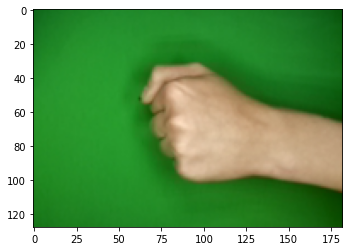

In [4]:
images, categories = get_data()

print("Image count:", len(images))
print("Image matrix: %d*%d*%d" %(len(images[0][0][0]),len(images[0][0]),len(images[0])))
plt.imshow(images[0])

In [5]:
train_ratio = 0.7
split_index = math.floor(len(images) * 0.7)

x_train, x_test = images[:split_index], images[split_index:]
y_train, y_test = categories[:split_index], categories[split_index:]

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255 # convert RGB -> 0..1
x_test /= 255 # convert RGB -> 0..1

y_train = utils.to_categorical(y_train, len(categories))
y_test = utils.to_categorical(y_test, len(categories))

print('count')
print(' x_train: %d | x_test: %d' %(x_train.shape[0], x_test.shape[0]))
print(' y_train: %d | y_test: %d' %(y_train.shape[0], y_test.shape[0]))

count
 x_train: 1531 | x_test: 657
 y_train: 1531 | y_test: 657


**Model design**

In [34]:
learning_rate = 0.2

batch_size = 5
epochs = 50
validation_split = 0.3

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [35]:
model = tf.keras.Sequential()
model.add(layers.Conv2D(16, (3,3), strides=(1,1), padding='same',
                        activation='relu', input_shape=input_shape, 
                        name='conv1'))
model.add(layers.MaxPooling2D((2,2), strides=(2,2), padding='same',
                        name='pool1'))
model.add(layers.Conv2D(32, (3,3), strides=(1,1), padding='same', 
                        activation='relu', input_shape=input_shape, 
                        name='conv2'))
model.add(layers.MaxPooling2D((2,2), strides=(2,2), padding='same', 
                        name='pool2'))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(len(categories), activation='softmax'))

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adadelta(learning_rate=learning_rate), 
              metrics=['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 128, 182, 16)      448       
                                                                 
 pool1 (MaxPooling2D)        (None, 64, 91, 16)        0         
                                                                 
 conv2 (Conv2D)              (None, 64, 91, 32)        4640      
                                                                 
 pool2 (MaxPooling2D)        (None, 32, 46, 32)        0         
                                                                 
 flatten_7 (Flatten)         (None, 47104)             0         
                                                                 
 dense_14 (Dense)            (None, 128)               6029440   
                                                                 
 dense_15 (Dense)            (None, 2188)             

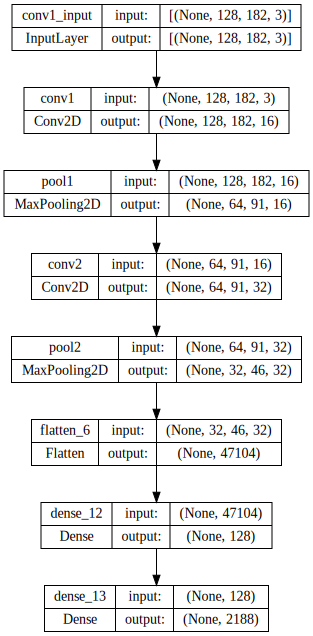

In [32]:
# draw model 

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(model, show_shapes=True, dpi=72).create(prog='dot', format='svg'))

In [36]:
hist = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=validation_split,
    callbacks=[early_stop],
    shuffle=True,
    verbose=1
)

score = model.evaluate(x_test, y_test, verbose=1)
print(' - test_loss:', score[0], ' - test_acc:', score[1])

model.save(dir + "model.h5")

Epoch 1/50
215/215 [==============================] - 34s 154ms/step - loss: 0.8298 - accuracy: 0.7068 - val_loss: 3.1750 - val_accuracy: 0.7674
Epoch 2/50
215/215 [==============================] - 30s 139ms/step - loss: 0.3061 - accuracy: 0.8674 - val_loss: 3.6495 - val_accuracy: 0.7022
Epoch 3/50
215/215 [==============================] - 29s 136ms/step - loss: 0.2171 - accuracy: 0.9076 - val_loss: 3.7300 - val_accuracy: 0.7870
Epoch 4/50
215/215 [==============================] - 28s 131ms/step - loss: 0.1526 - accuracy: 0.9421 - val_loss: 3.9732 - val_accuracy: 0.7326
Epoch 5/50
215/215 [==============================] - 29s 133ms/step - loss: 0.1212 - accuracy: 0.9552 - val_loss: 4.1680 - val_accuracy: 0.6935
Epoch 6/50
215/215 [==============================] - 29s 134ms/step - loss: 0.0962 - accuracy: 0.9683 - val_loss: 4.2738 - val_accuracy: 0.7130
Epoch 7/50
215/215 [==============================] - 29s 134ms/step - loss: 0.0841 - accuracy: 0.9720 - val_loss: 4.2252 - val_ac

<Figure size 1080x216 with 0 Axes>

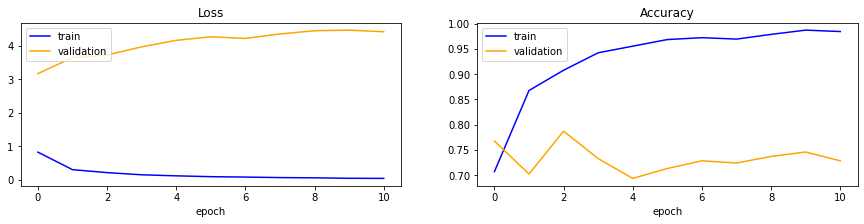

<Figure size 1080x216 with 0 Axes>

In [37]:
plt.figure(figsize=(15,3))

plt_loss = plt.subplot(1,2,1)

plt_loss.plot(hist.history['loss'], 'blue', label='train')
plt_loss.plot(hist.history['val_loss'], 'orange', label='validation')
plt_loss.set_title('Loss')
plt_loss.set_xlabel('epoch')
plt_loss.legend(loc='upper left')

plt_accuracy = plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'], 'blue', label='train')
plt_accuracy.plot(hist.history['val_accuracy'], 'orange', label='validation')
plt_accuracy.set_title('Accuracy')
plt_accuracy.set_xlabel('epoch')
plt_accuracy.legend(loc='upper left')
plt.figure(figsize=(15,3))

**Load Data**

중도 테스트를 위한 모델 불러오기

In [11]:
## load model file - 저장된 모델 사용 시만 사용 !
from tensorflow.python.keras.models import load_model

model = load_model("./model.h5")

OSError: ignored

테스트 이미지 1개 불러오기

In [ ]:
test_image = get_image_to_array(dir + "test_paper.png")
plt.imshow(test_image)
# 데이터 1개 테스트
test_image = test_image.astype('float32')
test_image /= 255
test_image = test_image.reshape((1,) + input_shape)

# model.predict(test_image)
predict = np.argmax(model.predict(test_image), axis=-1)[0]
category = categories[predict.tolist()]
print("predict:", category)


게임 로직

In [ ]:
from enum import Enum

class Rps(Enum):
  ROCK = 0
  PAPER = 1
  SCISSORS = 2

#my_hand = predict
#computer_hand = random.randrange(0,3)
#print(categories[my_hand], 'vs' , categories[computer_hand])

def rps_game(my_hand, computer_hand):
  if my_hand == Rps.ROCK.value:
    if computer_hand == Rps.ROCK.value:
      return "DRAW"
    elif computer_hand == Rps.PAPER.value:
      return "LOSS"
    elif computer_hand == Rps.SCISSORS.value:
      return "WIN"

  elif my_hand == Rps.PAPER.value:
    if computer_hand == Rps.ROCK.value:
      return "WIN"
    elif computer_hand == Rps.PAPER.value:
      return "DRAW"
    elif computer_hand == Rps.SCISSORS.value:
      return "LOSS"

  elif my_hand == Rps.SCISSORS.value:
    if computer_hand == Rps.ROCK.value:
      return "LOSS"
    elif computer_hand == Rps.PAPER.value:
      return "WIN"
    elif computer_hand == Rps.SCISSORS.value:
      return "DRAW"

In [ ]:
import pygame.camera
import pygame.image
import pygame.time
import sys
import random

pygame.init()

white = (255, 255, 255)
black = (0, 0, 0)

computer_hand_pos = (100, 100)
player_hand_pos = (500, 100)
hand_size = (300, 300)
timer_pos = (450, 160)

screen = pygame.display.set_mode( ( 960 , 640 ) ) # center: 480 * 320
pygame.display.set_caption("Rock Paper Scissor!")
screen.fill(white)

pygame.camera.init()
webcam = pygame.camera.Camera(pygame.camera.list_cameras()[0])
webcam.start()

ticks_timer=pygame.time.get_ticks()
font = pygame.font.Font(None, 40)

pygame.draw.rect(screen, black, computer_hand_pos+ hand_size) # computer hand bg
pygame.draw.rect(screen, black, player_hand_pos + hand_size) # player hand bg

pygame.display.flip()

while True :
    for e in pygame.event.get() :
        if e.type == pygame.QUIT :
            sys.exit()

    # draw cam
    cam_img = pygame.transform.scale(webcam.get_image(), hand_size)
    screen.blit(cam_img, player_hand_pos)

    # draw timer
    sec=3-(pygame.time.get_ticks()-ticks_timer)//1000
    time_text = font.render(str(sec), True, black)
    pygame.draw.rect(screen, white, timer_pos + (30, 30)) # time text bg
    screen.blit(time_text, timer_pos)

    pygame.display.flip()

    if sec==0: 
        screen.blit(cam_img, player_hand_pos)
        pygame.display.flip()

        
        
        pygame.time.delay(1000)
        ticks_timer=pygame.time.get_ticks()

